<a href="https://colab.research.google.com/github/retnowulandaridwi89-lgtm/Tugas-Deep-Learning-Lanjut/blob/main/41236692_Tugas__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - kl_loss: 4.0227 - reconstruction_loss: 403.8907 - total_loss: 407.9135 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - kl_loss: 6.1310 - reconstruction_loss: 266.6442 - total_loss: 272.7752 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.1061 - reconstruction_loss: 261.6323 - total_loss: 267.7384 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.1486 - reconstruction_loss: 259.2777 - total_loss: 265.4264 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.2210 - reconstruction_loss: 257.8463 - total_loss: 264.06

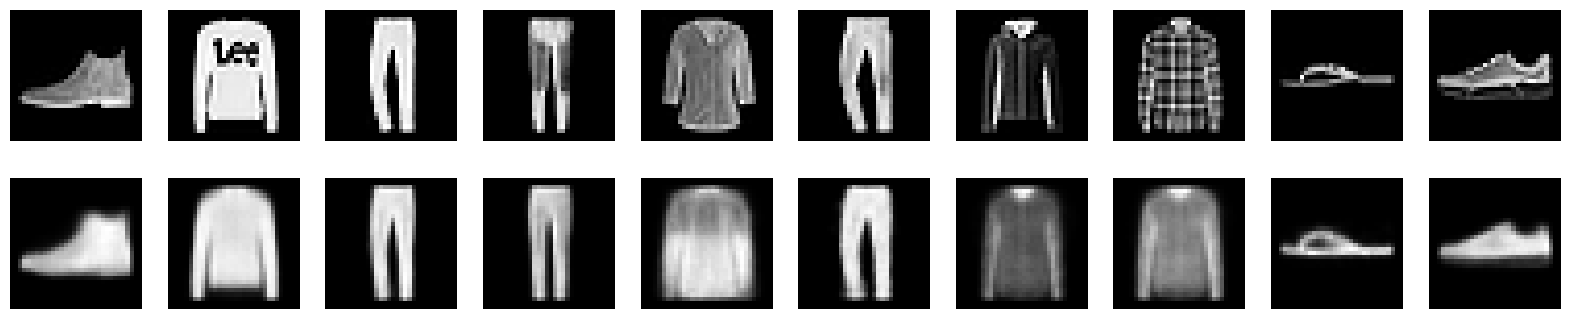

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


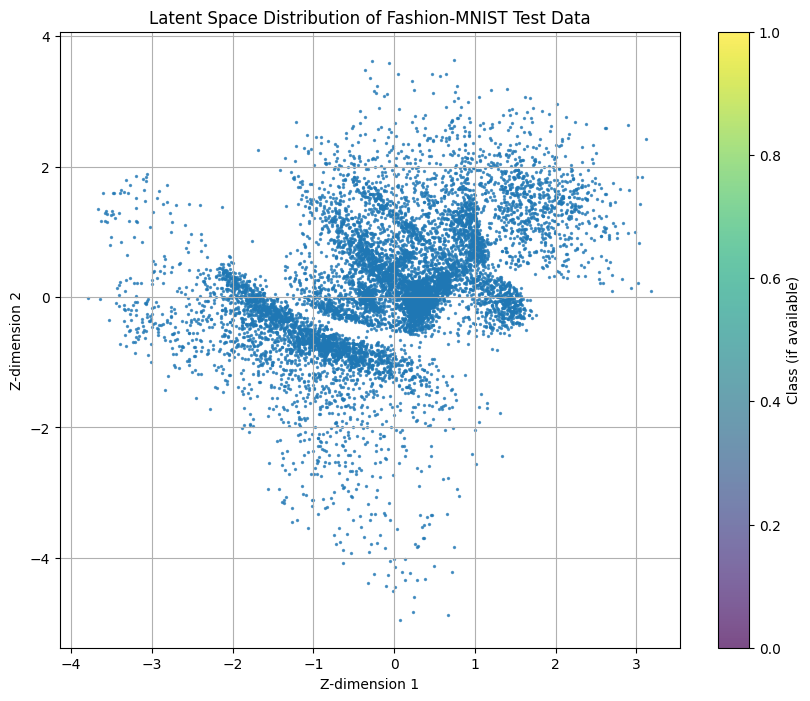

In [8]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [9]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [10]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[-1.1564074  -0.8613511 ]
 [ 0.2715295  -0.10889247]
 [ 2.4711676   0.88034165]
 [ 1.5970408   1.6016451 ]
 [-0.1359238   0.19069625]]


## Visualize Latent Space Distribution by Class



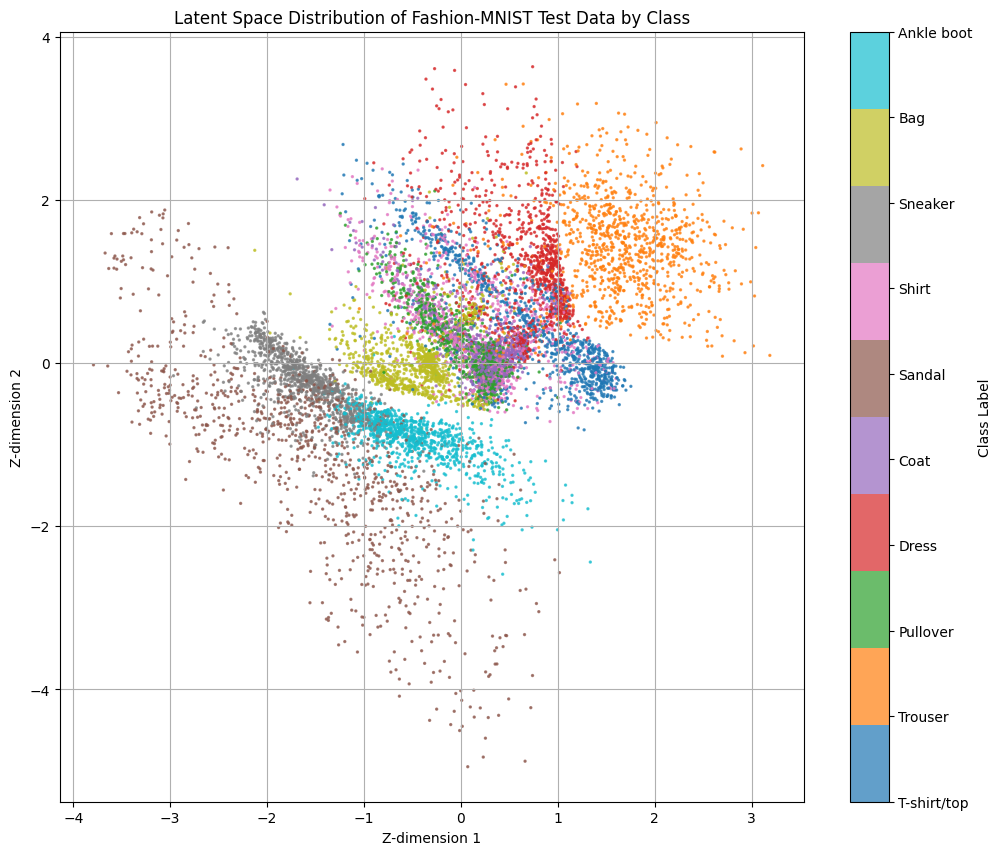

In [11]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

Memplot Grid Generasi dari Ruang Laten VAE (Menunjukkan Kontinuitas)


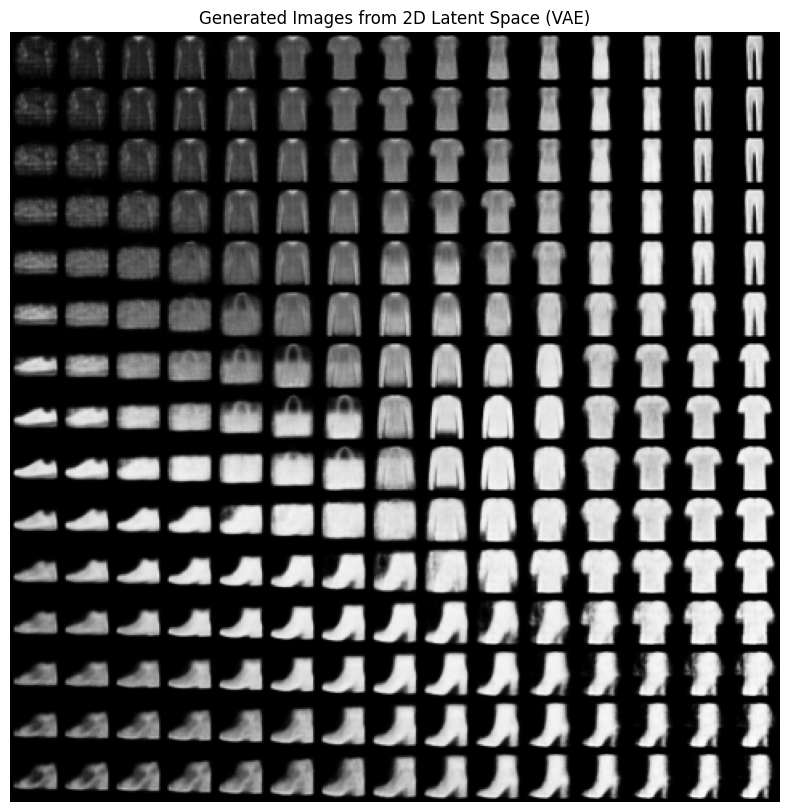

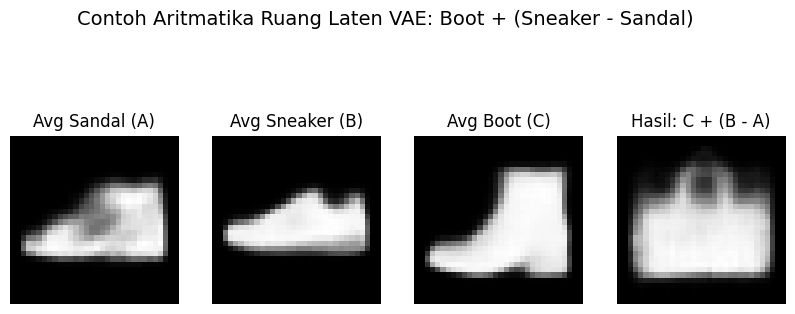

In [12]:
# Sel ke-7: Latent Space Visualization and Arithmetic

# Pastikan semua library yang dibutuhkan sudah terimport
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# --- 3A. Visualisasi Latent Space 2D (Generasi Grid) ---
def plot_latent_space(decoder_model, n=15, figsize=10):
    """Fungsi untuk memplot grid citra yang dihasilkan dari titik-titik di ruang laten 2D."""
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n))
    # Buat grid untuk latent space (z) dengan rentang yang sesuai (misalnya -1.5 hingga +1.5)
    grid_x = np.linspace(-1.5, 1.5, n)
    grid_y = np.linspace(-1.5, 1.5, n)[::-1] # Membalik y-axis

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            # Menggunakan decoder untuk menghasilkan citra
            x_decoded = decoder_model.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.title('Generated Images from 2D Latent Space (VAE)')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.axis('off')
    plt.show()

print("Memplot Grid Generasi dari Ruang Laten VAE (Menunjukkan Kontinuitas)")
plot_latent_space(decoder) # Menggunakan decoder yang sudah didefinisikan sebelumnya

# --- 3B. Latent Space Arithmetic Example ---
# Label Fashion-MNIST: 5: Sandal, 7: Sneaker, 9: Ankle boot
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()

# Dapatkan latent mean (z_mean) untuk seluruh test set
# Variabel 'encoder' dari sel sebelumnya digunakan
z_mean_test, _, _ = encoder.predict(x_test, batch_size=128, verbose=0)

# Fungsi helper untuk menghitung rata-rata vektor laten per kelas
def get_mean_latent(class_id, z_mean, y_labels):
    mask = (y_labels == class_id)
    return np.mean(z_mean[mask], axis=0)

# Hitung mean latent vector untuk kelas yang akan diuji
z_sandal = get_mean_latent(5, z_mean_test, y_test)
z_sneaker = get_mean_latent(7, z_mean_test, y_test)
z_boot = get_mean_latent(9, z_mean_test, y_test)

# Aritmatika Ruang Laten: (Sneaker - Sandal) + Ankle Boot
# Arah dari sandal ke sneaker diterapkan pada ankle boot
z_arithmetic = z_boot + (z_sneaker - z_sandal)

# Decode hasil aritmatika
arithmetic_result = decoder.predict(np.expand_dims(z_arithmetic, 0), verbose=0)[0]

# Tampilkan hasil
plt.figure(figsize=(10, 4))

plt.subplot(1, 4, 1)
plt.imshow(decoder.predict(np.expand_dims(z_sandal, 0), verbose=0)[0].reshape(32, 32), cmap='Greys_r')
plt.title('Avg Sandal (A)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(decoder.predict(np.expand_dims(z_sneaker, 0), verbose=0)[0].reshape(32, 32), cmap='Greys_r')
plt.title('Avg Sneaker (B)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(decoder.predict(np.expand_dims(z_boot, 0), verbose=0)[0].reshape(32, 32), cmap='Greys_r')
plt.title('Avg Boot (C)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(arithmetic_result.reshape(32, 32), cmap='Greys_r')
plt.title('Hasil: C + (B - A)')
plt.axis('off')

plt.suptitle('Contoh Aritmatika Ruang Laten VAE: Boot + (Sneaker - Sandal)', y=1.02, fontsize=14)
plt.show()

In [13]:
# Sel ke-8: Bangun dan Latih Autoencoder (AE) Biasa

# latent_dim dan shape_before_flattening dipertahankan dari sel sebelumnya.

# --- AE Encoder ---
ae_encoder_input = layers.Input(shape=(32, 32, 1), name="ae_encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ae_encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
z_ae = layers.Dense(latent_dim, name="z_ae")(x) # Vektor laten tunggal
ae_encoder = models.Model(ae_encoder_input, z_ae, name="ae_encoder")
print("AE Encoder Summary:")
ae_encoder.summary()

# --- AE Decoder (Struktur sama dengan VAE decoder) ---
ae_decoder_input = layers.Input(shape=(latent_dim,), name="ae_decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(ae_decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
ae_decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
ae_decoder = models.Model(ae_decoder_input, ae_decoder_output, name="ae_decoder")
print("\nAE Decoder Summary:")
ae_decoder.summary()

# --- Autoencoder Model Penuh ---
autoencoder_output = ae_decoder(ae_encoder(ae_encoder_input))
autoencoder = models.Model(ae_encoder_input, autoencoder_output, name="Autoencoder")
print("\nAutoencoder (AE) Summary:")
autoencoder.summary()

# --- Kompilasi dan Latih AE ---
# AE dilatih hanya dengan Reconstruction Loss (Binary Crossentropy)
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy())
print("\nMelatih Standard Autoencoder (AE)...")

# x_train dan x_test digunakan sebagai input dan target
history_ae = autoencoder.fit(x_train, x_train,
                              epochs=5,
                              batch_size=128,
                              shuffle=True,
                              validation_data=(x_test, x_test))

AE Encoder Summary:


Model: "ae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_encoder_input (InputLayer)   │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_ae (Dense)                    │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)


AE Decoder Summary:


Model: "ae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_decoder_input (InputLayer)   │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder (AE) Summary:


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_encoder_input (InputLayer)   │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_encoder (Functional)         │ (None, 2)              │        96,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_decoder (Functional)         │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)


Melatih Standard Autoencoder (AE)...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.3977 - val_loss: 0.2699
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2650 - val_loss: 0.2603
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2584 - val_loss: 0.2569
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2555 - val_loss: 0.2551
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2533 - val_loss: 0.2536



Memplot Perbandingan Rekonstruksi...


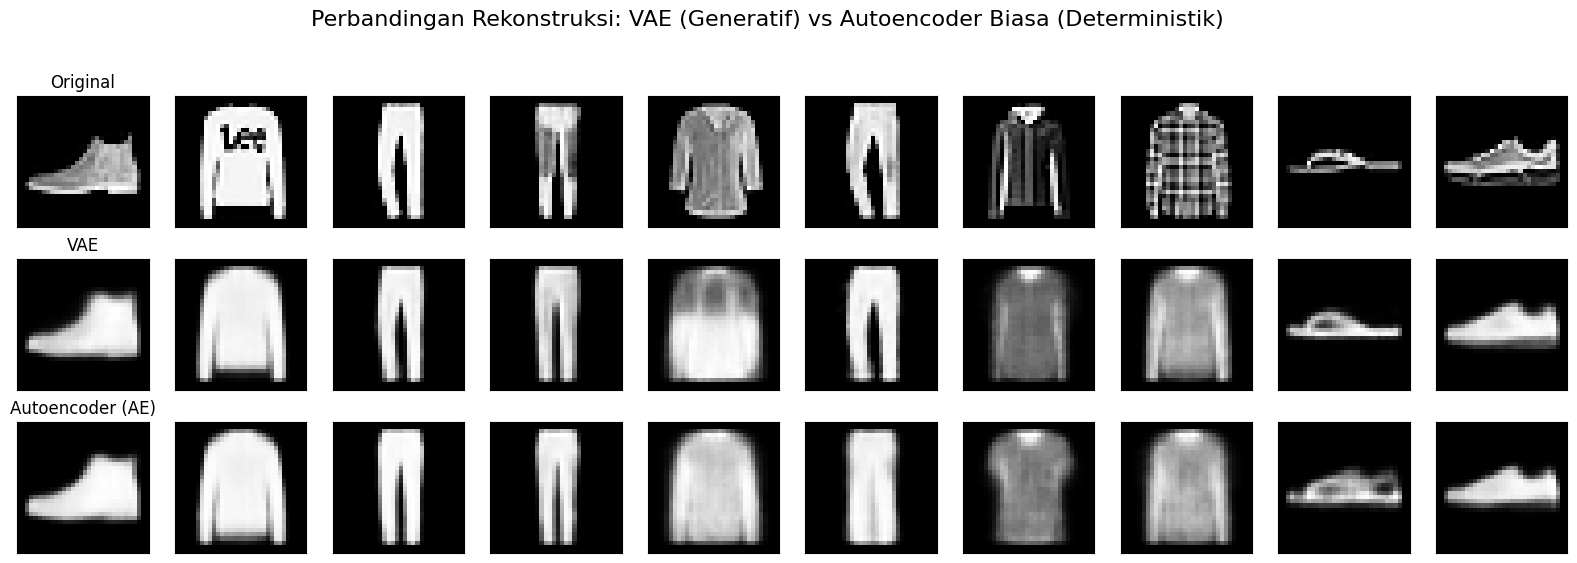

In [14]:
# Sel ke-9: Plotting Perbandingan Rekonstruksi VAE vs AE

def plot_comparative_reconstructions(x_original, vae_model, ae_model, n=10):
    """Memplot citra asli, rekonstruksi VAE, dan rekonstruksi AE secara berdampingan."""
    plt.figure(figsize=(20, 6))

    # Ambil 10 contoh pertama dari test set
    x_display = x_original[:n]

    # Rekonstruksi VAE
    # Output vae.predict adalah [z_mean, z_log_var, reconstruction]
    vae_reconstructions = vae_model.predict(x_display, verbose=0)[2]

    # Rekonstruksi AE
    ae_reconstructions = ae_model.predict(x_display, verbose=0)

    for i in range(n):
        # 1. Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_display[i].reshape(32, 32), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.title('Original')

        # 2. VAE Reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_reconstructions[i].reshape(32, 32), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.title('VAE')

        # 3. AE Reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_reconstructions[i].reshape(32, 32), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.title('Autoencoder (AE)')

    plt.suptitle('Perbandingan Rekonstruksi: VAE (Generatif) vs Autoencoder Biasa (Deterministik)', y=1.02, fontsize=16)
    plt.show()

print("\nMemplot Perbandingan Rekonstruksi...")
plot_comparative_reconstructions(x_test, vae, autoencoder, n=10)